In [1]:
import os 
import glob 

import numpy as np
import pandas as pd

from metpy.calc import wind_speed
from metpy.calc import wind_direction 
from metpy.units import units

import matplotlib.pyplot as plt
from   matplotlib.lines import Line2D
import matplotlib.dates as mdates
import seaborn as sns

import cv2
from PIL import Image
import os
import glob
import re

from pathlib import Path

sns.set_theme(style="whitegrid")

# Functions

In [49]:
def prep_wrf_data(fpath, var_name_dict, site):
    """
    Reads and prepares WRF data

    Reads in data, convert temperature from K to C, casts index to DateTime format, calculates
    wind speed and direction, and returns the prepared dataframe

    Parameters
    ----------
    df_fpath : str
        Path to file containing the data.
    var_name_dict : dict
        Dictionary of variable rename mappings to.
    
    Returns
    -------
    pd.Dataframe
        The prepared dataframe. 
    """
    df = pd.read_pickle(fpath)
    df['T2'] = df['T2'] - 273  # Convert K to C
    df.index = df.index - pd.Timedelta(hours=8)  # UTC to local
    wnd_spd, wnd_dir = get_wind(df['U10'].values, df['V10'].values)
    df['WND_SPD'] = wnd_spd
    df['WND_DIR'] = wnd_dir
    df.rename(columns=var_name_dict, inplace=True)
    
    df.attrs['site'] = site
    df.attrs['source'] = 'wrf'
    
    return df

def prep_obs_data(fpath, site):
    """
    Reads and prepares WRF data

    Reads in data, convert temperature from K to C, casts index to DateTime format, calculates
    wind speed and direction, and returns the prepared dataframe

    Parameters
    ----------
    fpath : str
        Path to file containing the data.
    site : str 
        The site the data corresponds to.

    Returns
    -------
    pd.Dataframe
        The prepared dataframe. 
    """
    
    df = pd.read_csv(fpath, index_col='time (PST)')
    df.index = pd.to_datetime(df.index)
    
    df.attrs['site'] = site
    df.attrs['source'] = 'obs'
    
    return df

def get_wind(u, v): 
    """"
    Calculates wind speed and direction from velocity components

    Parameters
    -----------
    u : np.Series
        The x wind component.
    v : np.Series  
        The y wind component. 

    Returns
    -------
    wind_speed : float
        Calculated wind speed.
    wind_dir : float
        Calculated wind direction.
    """
    u = u * units('m/s')
    v = v * units('m/s')

    wnd_spd = wind_speed(u,v)
    wnd_dir = wind_direction(u, v, convention='from')
    
    return wnd_spd, wnd_dir

def plot_fog(fog_df, daterange, site, vertical_time, variable='variable', outfpath=None, display_plot=True, shape=[1032, 553]):
    """
    Plot timeseries lineplot of relative humidity overlaid with a bar plot of fog events occurrence. Plots both WRF and Observational 
    on the same plot.

    Parameters
    ----------
    fog_df : pd.DataFrame
        Dataframe with fog and relative humidity observations.
    daterange : list of str
        Date range to subset data to. Should be in the form [From, To], or ['YYYY-MM-DD','YYYY-MM-DD'].
    site : str
        Site to plot for. 
    
    Returns
    -------
        None
    """
    wfog = fog_df.loc[fog_df['source'] == 'wrf']
    ofog = fog_df.loc[fog_df['source'] == 'obs']

    wfog = wfog[daterange[0] : daterange[1]]
    ofog = ofog[daterange[0] : daterange[1]]

    year = daterange[0].split('-')[0]
    month = daterange[0].split('-')[1]

    width = shape[0] / 100
    height = shape[1] / 100

    fig, ax = plt.subplots(figsize=(width, height))
    ax2 = ax.twinx()
    ax.plot(wfog.index, wfog[variable], color='blue', label=f'WRF {variable}')
    ax.plot(ofog.index, ofog[variable], color='orange', label=f'Obs {variable}')

    ax2.bar(wfog.index, wfog['binary fog'], alpha=0.4, color='lightblue', width=0.1, label='WRF Fog')
    ax2.bar(ofog.index, ofog['binary fog'], alpha=0.2, color= 'gray', width=0.1, label='Obs Fog')
    ax2.get_yaxis().set_visible(False)

    ax.axvline(pd.to_datetime(vertical_time), color='red', linestyle='--', linewidth=2, alpha=0.85)

    ax.set(title=f'Model vs. Observational\n {site} {month}/{year}',
           ylabel=variable)

    fig.legend(loc='upper right', bbox_to_anchor=(1.09, .99), bbox_transform=ax.transAxes)

    if outfpath:
        plt.savefig(outfpath)
    
    if display_plot == True:
        plt.show()
    else:
        plt.close()


def concat_img(cld_img, ts_img):
    if cld_img.shape[1] == ts_img.shape[2]:
        concat_img = cv2.vconcat([ts_img, cld_img])
    else:
        # Get dimensions
        cld_width = cld_img.shape[1]  # Width of cld_img
        ts_height, ts_width = ts_img.shape[:2]  # Original dimensions of ts_img

        # Compute new height while keeping the aspect ratio
        aspect_ratio = ts_height / ts_width
        new_height = int(cld_width * aspect_ratio)

        # Resize ts_img
        ts_img_resized = cv2.resize(ts_img, (cld_width, new_height))

        concat_img = cv2.vconcat([ts_img_resized, cld_img])

    return concat_img

# Read in and Prepare Data

In [22]:
# Define root and data directories

root_dir = Path().resolve().parents[1]
data_dir = root_dir / "data"

In [23]:
var_name_dict = {
    'DFGDP' : 'fog drip',
    'T2' : 'air temperature (C)',
    'RH' : 'relative humidity (%)',
    'WND_SPD' : 'wind speed (m/s)',
    'WND_DIR' : 'wind direction (deg)'
}

#### WRF file paths ####
wdatadir = data_dir / 'wrf-extracted' / 'single-pixel'
wsauc_fname = 'wrf-sauc-2003-2010.pkl'
wupem_fname = 'wrf-upem-2003-2010.pkl'

#### Obs file paths ####
odatadir = data_dir / 'observational' / 'aggregated-datasets'
osauc_fname = 'sauc-hourly.csv'
oupem_fname = 'upem-hourly.csv'

#### Read in data ####
wsauc = prep_wrf_data(os.path.join(wdatadir, wsauc_fname), var_name_dict, site='Sauces Canyon')
wupem = prep_wrf_data(os.path.join(wdatadir, wupem_fname), var_name_dict, site='Upper Embudo Canyon')

osauc = prep_obs_data(os.path.join(odatadir, osauc_fname), site='Sauces Canyon')
oupem = prep_obs_data(os.path.join(odatadir, oupem_fname), site='Upper Embudo Canyon')


# Join all into a single dataframe
df_list = [wsauc, wupem, osauc, oupem]
for df in df_list:
    df['site'] = df.attrs['site']
    df['source'] = df.attrs['source']

df = pd.concat(df_list, join='inner', axis=0)
df.head(2)

,air temperature (C),relative humidity (%),wind speed (m/s),wind direction (deg),site,source
2002-06-30 16:00:00,16.731750,87.381705,3.002108,218.612980,Sauces Canyon,wrf
2002-06-30 17:00:00,18.919373,74.644099,0.134169,118.507522,Sauces Canyon,wrf


In [37]:
# Prepare Fog Data
osauc = osauc.rename({'fog' : 'fog drip'}, axis=1)
oupem = oupem.rename({'fog' : 'fog drip'}, axis=1)

var_list = ['fog drip', 'relative humidity (%)', 'wind speed (m/s)', 'wind direction (deg)', 'source']

# Define Sauces Fog
wsauc_fog = wsauc[var_list]
osauc_fog = osauc[var_list]

sauc_fog = pd.concat([wsauc_fog, osauc_fog], axis=0)
sauc_fog['binary fog'] = sauc_fog['fog drip'].apply(lambda x: 1 if x > 0 else 0)
sauc_fog.head()

# Define Upem Fog
wupem_fog = wupem[var_list]
oupem_fog = oupem[var_list]

upem_fog = pd.concat([wupem_fog, oupem_fog], axis=0)
upem_fog['binary fog'] = upem_fog['fog drip'].apply(lambda x: 1 if x > 0 else 0)
upem_fog.head()

,fog drip,relative humidity (%),wind speed (m/s),wind direction (deg),source,binary fog
2002-06-30 16:00:00,0.0,86.297667,3.036855,218.233735,wrf,0
2002-06-30 17:00:00,0.0,72.221067,0.736050,190.393139,wrf,0
2002-06-30 18:00:00,0.0,69.414770,0.894155,240.237483,wrf,0
2002-06-30 19:00:00,0.0,77.571347,0.934764,224.940523,wrf,0
2002-06-30 20:00:00,0.0,76.824697,0.400207,225.428902,wrf,0


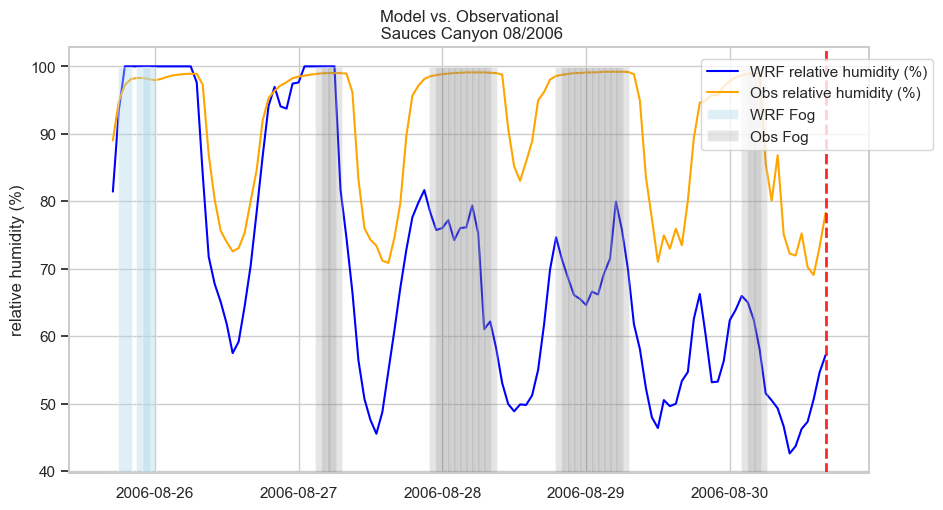

In [52]:
plot_fog(sauc_fog, ['2006-08-25 17:00:00','2006-08-30 16:00:00'], "Sauces Canyon", variable='relative humidity (%)', vertical_time='2006-08-30 16:00:00', display_plot=True, outfpath=None)

# Save out figure for every hour

In [11]:
# Check WRF map image size 
img = cv2.imread('/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-wrf-analysis/outputs/spatial-analysis-figs/wrf-clouds-sci/wrf-clouds-with-wind-vectors/Fig_clouds_Fog.00001.png')
img.shape

(1200, 1800, 3)

In [40]:
variable = 'wind speed (m/s)'

dateranges = [['2008-08-16 17:00:00','2008-08-18 16:00:00'], 
              ['2008-08-23 17:00:00','2008-08-25 16:00:00']]

width = 1800
height = 600

var_str = (variable.split(' ')[0:-1])
var_str = '-'.join(var_str)

for daterange in dateranges:
    dates = [date.split(' ')[0] for date in daterange]
    months = [date.split('-')[1] for date in dates]
    days = [date.split('-')[2] for date in dates]


    outdir_root = '/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-wrf-analysis/outputs/spatial-analysis-figs/obs-timeseries/'
    outdir_name = f'{var_str}-{months[0]}-{days[0]}_{months[1]}-{days[1]}/'

    if not os.path.isdir(outdir_root + outdir_name):
        os.mkdir(outdir_root + outdir_name)

    time_range = pd.date_range(start=daterange[0], end=daterange[1], freq='h')
    i = 1
    for timestamp in time_range:
        outfpath = os.path.join(outdir_root + outdir_name, f'{i}-sauc-{timestamp}.png')
        plot_fog(sauc_fog, daterange, "Sauces Canyon", variable=variable, vertical_time=timestamp, display_plot=False, outfpath=outfpath, shape=[width, height])

        i+=1
    print(outfpath)

/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-wrf-analysis/outputs/spatial-analysis-figs/obs-timeseries/wind-speed-08-16_08-18/48-sauc-2008-08-18 16:00:00.png
/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-wrf-analysis/outputs/spatial-analysis-figs/obs-timeseries/wind-speed-08-23_08-25/48-sauc-2008-08-25 16:00:00.png


# Concatenate Images 

In [43]:
start_dates = ['08-16', '08-23']
end_dates = ['08-18', '08-25']
#var_str = 'wind-speed'

# Define directories 
for i in range(len(start_dates)):
    start_date = start_dates[i]
    end_date = end_dates[i]

    figs_root_dir = root_dir / 'outputs/spatial-analysis-figs'
    cld_dir = figs_root_dir / 'wrf-clouds-sci' / 'wrf-clouds-with-wind-field' / f'{start_date}_{end_date}'
    ts_dir = figs_root_dir / 'obs-timeseries' / f'{var_str}-{start_date}_{end_date}'
    outdir = figs_root_dir / 'combined-figs' / f'{var_str}-ts-clouds-with-wind-field_{start_date}_{end_date}'

    # Make directory if it doesn't exist
    if not outdir.is_dir():
        os.mkdir(outdir)

    # Define whether to use fog or low clouds
    # layer = 'Fog'

    ts_files = [os.path.basename(x) for x in glob.glob(str(ts_dir) + '/*.png')]
    ts_files = sorted(ts_files, key=lambda x: int(re.match(r'(\d+)-', x).group(1)))  # Sort using prefix number

    cld_files = [os.path.basename(x) for x in glob.glob(str(cld_dir) + '/*.png')]
    cld_files = sorted(cld_files)

    for i in range(len(cld_files)):
        cld_img = cv2.imread(os.path.join(cld_dir, cld_files[i]))
        ts_img = cv2.imread(os.path.join(ts_dir, ts_files[i]))

        img = concat_img(cld_img, ts_img)

        outfpath = os.path.join(outdir, ts_files[i])
        cv2.imwrite(outfpath, img)

    print(outdir)

/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-wrf-analysis/outputs/spatial-analysis-figs/combined-figs/wind-speed-ts-clouds-with-wind-field_08-16_08-18
/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-wrf-analysis/outputs/spatial-analysis-figs/combined-figs/wind-speed-ts-clouds-with-wind-field_08-23_08-25


# Join GOES CLC and WRF CLC images

In [58]:
root_dir = Path().resolve().parents[1]
wrf_img_dir = root_dir / 'outputs' / 'spatial-analysis-figs' / 'wrf-clouds-sci' / 'wrf-clouds-with-wind-vectors'
goes_img_dir = root_dir / 'outputs' / 'spatial-analysis-figs' / 'clc-albedo' / '08-23_08-25'
goes_imgs = sorted([os.path.basename(f) for f in glob.glob(str(goes_img_dir) + '/*.png')])
wrf_imgs = [f for f in os.listdir(wrf_img_dir) if "wrf-clouds-Low" in f]

matched_imgs = []
for img in goes_imgs:
    timestamp = img[14:-4]
    wrf_img = [f for f in wrf_imgs if timestamp in f]
    if len(wrf_img) >= 1:
        matched_imgs.append([img, wrf_img[0]])

In [59]:
daterange = str(goes_img_dir).split('/')[-1]
outdir = root_dir / 'outputs' / 'spatial-analysis-figs' / 'combined-figs' / 'wrf-clouds-clc-comparison' / f'{daterange}-albedo'

# Make directory if it doesn't exist
if not outdir.is_dir():
    os.mkdir(outdir)

# Define directories 
for i in range(len(matched_imgs)):
    goes_file = goes_img_dir / matched_imgs[i][0]
    wrf_file = wrf_img_dir / matched_imgs[i][1]

    time = matched_imgs[i][0][14:-4]
    out_fname = f'{str(i).zfill(2)}-clc-comparison-{time}.png'

    goes_img = cv2.imread(goes_file)
    wrf_img = cv2.imread(wrf_file)

    img = concat_img(goes_img, wrf_img)

    outfpath = outdir / out_fname
    cv2.imwrite(outfpath, img)

print(outdir)

/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-wrf-analysis/outputs/spatial-analysis-figs/combined-figs/wrf-clouds-clc-comparison/08-23_08-25-albedo
